In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
from xml.dom import minidom


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_PATH = Path('F:/fastai/courses/dl2/data/road_damage_dataset')

In [4]:
govs =  ["Adachi", "Chiba", "Ichihara", "Muroran", "Nagakute", "Numazu", "Sumida"]

In [5]:
test_images = []
for gov in govs:
    test_images.extend([os.path.join(gov, 'JPEGImages', file) for file in os.listdir(os.path.join(DATA_PATH, gov, 'JPEGImages')) if file.startswith('test_')])

df = pd.DataFrame(test_images, columns=['filename'])
df.to_csv(DATA_PATH/'test_data.csv')

In [6]:
train_files = []
for gov in govs:
    train_files.extend([os.path.join(DATA_PATH, gov, 'Annotations', file) for file in os.listdir(os.path.join(DATA_PATH, gov, 'Annotations'))])

In [7]:
train_data = []

In [8]:
for file in train_files:
    doc = minidom.parse(file)  
    anno = doc.getElementsByTagName('annotation')[0]
    folder = anno.getElementsByTagName('folder')[0].firstChild.nodeValue
    filename = folder + "/JPEGImages/" + anno.getElementsByTagName('filename')[0].firstChild.nodeValue
    objects = anno.getElementsByTagName('object')
    for obj in objects:
        cls = obj.getElementsByTagName('name')[0].firstChild.nodeValue
        if cls == "D30": continue
        bndbox = obj.getElementsByTagName('bndbox')[0]
        xmin = bndbox.getElementsByTagName('xmin')[0].firstChild.nodeValue
        ymin = bndbox.getElementsByTagName('ymin')[0].firstChild.nodeValue
        xmax = bndbox.getElementsByTagName('xmax')[0].firstChild.nodeValue
        ymax = bndbox.getElementsByTagName('ymax')[0].firstChild.nodeValue
        
        d = {"filename": filename, "width": 600, "height": 600, "class": cls, "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax}
        train_data.append(d)

In [9]:
df = pd.DataFrame(train_data, columns=['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])

In [10]:
df.to_csv(DATA_PATH/'data.csv')

In [11]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=(2,2), dpi=300)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return fig,ax

In [12]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [13]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=.5))
    draw_outline(patch, .5)

In [14]:
def draw_text(ax, xy, txt, sz=4):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, .5)

In [15]:
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [16]:
examples = pd.read_csv(DATA_PATH/'data.csv')
images = split(examples, 'filename')

In [17]:
def print_example_from_data(im, bbs, cats, ax=None):
    if ax is not None:
        show_img(im, ax=ax)
    else:
        fig, ax = show_img(im)
        
    for bb, cat in zip(util.partition(bbs, 4), cats):
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], cat)

In [18]:
def print_example(example, ax=None):
    im = ImageData.open_image(DATA_PATH/example.filename)
    if ax is not None:
        show_img(im, ax=ax)
    else:
        fig, ax = show_img(im)
    for index, row in example.object.iterrows():
        bb = corners_to_hw([row['xmin'], row['ymin'], row['xmax'], row['ymax']]) # Bounding box converted to height width
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], row['class']) 
        
    fig.savefig('save2.png')

In [19]:
potholes = []
for ob in images:
    for index, row in ob.object.iterrows():
        if(row['class'] == "D40"):
            potholes.append(ob)
            break;

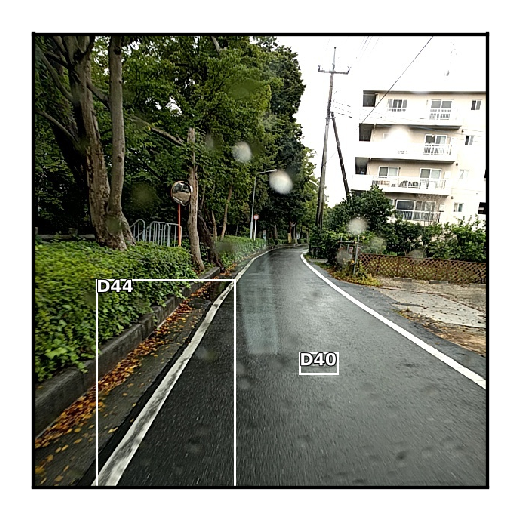

In [20]:
print_example(potholes[6]) 

In [21]:
images[0]

data(filename='Adachi/JPEGImages/train_Adachi_00001.jpg', object=   Unnamed: 0                                  filename  width  height class  \
0           0  Adachi/JPEGImages/train_Adachi_00001.jpg    600     600   D44   
1           1  Adachi/JPEGImages/train_Adachi_00001.jpg    600     600   D10   

   xmin  ymin  xmax  ymax  
0   424   361   590   546  
1   114   432   487   543  )

In [22]:
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'

In [23]:
mc = [[row['class'] for index, row in img.object.iterrows()] for img in images]
mcs = [' '.join(label for label in labels) for labels in mc]
print(mc[0:4])
print(mcs[0:4])

[['D44', 'D10'], ['D01', 'D01'], ['D01'], ['D01', 'D00']]
['D44 D10', 'D01 D01', 'D01', 'D01 D00']


In [24]:
df = pd.DataFrame({'filename': [img.filename for img in images], 'class': mcs}, columns=['filename','class'])
df.to_csv(MULTICLASS_CSV_PATH, index=False)

In [25]:
MULTIBB_CSV_PATH = DATA_PATH/'bb.csv'

In [26]:
print(images[0].object)

   Unnamed: 0                                  filename  width  height class  \
0           0  Adachi/JPEGImages/train_Adachi_00001.jpg    600     600   D44   
1           1  Adachi/JPEGImages/train_Adachi_00001.jpg    600     600   D10   

   xmin  ymin  xmax  ymax  
0   424   361   590   546  
1   114   432   487   543  


In [27]:
mbb = [np.concatenate([[row['xmin'], row['ymin'], row['xmax'], row['ymax']] for index, row in img.object.iterrows()]) for img in images]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

In [28]:
df = pd.DataFrame({'filename': [img.filename for img in images], 'bbox': mbbs}, columns=['filename','bbox'])
df.to_csv(MULTIBB_CSV_PATH, index=False)

In [29]:
df.head()

,filename,bbox
0,Adachi/JPEGImages/train_Adachi_00001.jpg,424 361 590 546 114 432 487 543
1,Adachi/JPEGImages/train_Adachi_00002.jpg,113 353 260 592 318 300 455 582
2,Adachi/JPEGImages/train_Adachi_00003.jpg,474 344 598 493
3,Adachi/JPEGImages/train_Adachi_00004.jpg,362 228 524 578 130 310 399 589
4,Adachi/JPEGImages/train_Adachi_00005.jpg,232 413 328 580
